In [ ]:
# import sys
# sys.path.append("c:/Users/vinit/Downloads/Research/Quantum-Sampling")
# from spin_utils import *

In [8]:
import matplotlib.pyplot as plt

# pip install netket jax jaxlib  (if you haven't already; on GPU, install the right jaxlib)
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
from jax.flatten_util import ravel_pytree

In [ ]:
L = 12                 # number of spins
h = 1.0                # transverse field
J = 1.0                # interaction strength

graph = nk.graph.Chain(L, pbc=True)
hi = nk.hilbert.Spin(s=0.5, N=L)

# Built-in fast TFIM Hamiltonian:  H = -h Σ σ^x_i + J Σ⟨i,j⟩ σ^z_i σ^z_j
H = nk.operator.Ising(hilbert=hi, graph=graph, h=h, J=J)

# ----------------------------
# Ansatz + Sampler + VState
# ----------------------------
alpha = 1              # hidden unit density (M = alpha * N)
sigma = 1          # stddev for normal initialization of RBM params
normal_init = jax.nn.initializers.normal(sigma)

model = nk.models.RBM(
    alpha=alpha,
    param_dtype=jnp.float64,          # use float64 for good numerical stability
)

sampler = nk.sampler.MetropolisLocal(hi)               # local spin flips
vstate = nk.vqs.MCState(
    sampler,
    model,
    n_samples=4096,           # total MC samples per gradient estimate
    seed=12345,               # base seed; we will re-init params with different seeds below
)

# We'll flatten parameter/gradient PyTrees to vectors so we can stack and take variances.
# The ravel function depends on the parameter structure, so build it once now.
flat_params, unravel = ravel_pytree(vstate.parameters)
n_params = flat_params.size
print(f"Total number of parameters: {n_params}")

# ----------------------------
# Repeat experiment many times
# ----------------------------
n_trials = 100
all_grads = np.empty((n_trials, n_params), dtype=np.float64)

for t in range(n_trials):
    # Re-initialize the RBM parameters with a fresh random seed
    vstate.init_parameters(normal_init, seed=1000 + t)   # re-draws parameters from a small normal dist

    # (Optional) refresh cached samples; MCState will resample if needed,
    # but calling reset() makes it explicit.
    vstate.reset()

    # Estimate <H> and its gradient wrt parameters
    # expect_and_grad returns (Stats, grad_pytree)
    E_stats, grad_tree = vstate.expect_and_grad(H)

    # Flatten gradient PyTree to a 1D vector and store
    grad_vec, _ = ravel_pytree(grad_tree)
    all_grads[t] = np.asarray(grad_vec)

Total number of parameters: 168


In [53]:
def remove_outliers_iqr(all_grads, k=5):
    """
    Removes outliers from all_grads (n_trials × n_params) per parameter column.
    Outliers are defined as values outside [Q1 - k*IQR, Q3 + k*IQR].
    
    Returns a masked array where outliers are masked (NaN).
    """
    # Q1 = np.percentile(all_grads, 25, axis=0, keepdims=True)
    # Q3 = np.percentile(all_grads, 75, axis=0, keepdims=True)
    # IQR = Q3 - Q1
    
    # lower = Q1 - k * IQR
    # upper = Q3 + k * IQR

    lower = np.percentile(all_grads, 1, axis=0, keepdims=True)
    upper = np.percentile(all_grads, 99, axis=0, keepdims=True)
    
    mask = (all_grads >= lower) & (all_grads <= upper)
    
    cleaned = np.where(mask, all_grads, np.nan)
    
    return cleaned

all_grads_no_outliers = remove_outliers_iqr(all_grads, k=1.5)

In [56]:
nan_count = np.isnan(all_grads_no_outliers).sum()
nan_count / all_grads_no_outliers.size * 100

2.0

In [57]:
# ----------------------------
# Variance calculations
# ----------------------------
N = L               # number of visible units
M = alpha * N      # number of hidden units

b_var = np.nanvar(all_grads_no_outliers[:, :N], ddof=1)  
W_var = np.nanvar(all_grads_no_outliers[:, N: N + M * N], ddof=1)
a_var = np.nanvar(all_grads_no_outliers[:, N + M * N:], ddof=1)

print(f"Variance of gradient components (over {n_trials} trials):")
print(f"  Visible biases (b):      {b_var:.6e}")
print(f"  Weights (W):             {W_var:.6e}")
print(f"  Hidden biases (a):       {a_var:.6e}")

Variance of gradient components (over 100 trials):
  Visible biases (b):      4.511720e+00
  Weights (W):             3.054538e+00
  Hidden biases (a):       4.356068e+00


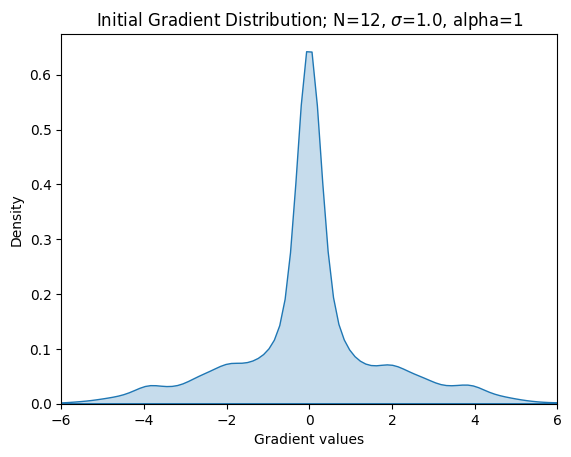

In [64]:
import seaborn as sns
plt.figure()
sns.kdeplot(all_grads_no_outliers.reshape(-1), fill=True, bw_adjust=1)
plt.title(r"Initial Gradient Distribution; N=%d, $\sigma$=%.1f, alpha=%d" % (N, sigma, alpha))
plt.xlabel("Gradient values")
plt.xlim(-6, 6)
plt.show()
